Here is the corrected, fully integrated **Google Colab Notebook**.

I have aligned this strictly with the **methods found in your uploaded source files**:

* **Outlier Detection**: Switched to **Isolation Forest** (found in `Outleir detection.ipynb`) instead of the basic IQR method.
* **Ensemble**: Switched to **Balanced Random Forest** (found in `Balancing techniques.ipynb`), which is more advanced than a standard Random Forest for imbalanced data.
* **Balancing**: Used **SMOTE** (found in `Balancing techniques.ipynb`) specifically for the SVM model.
* **Scaling**: Used **StandardScaler** (found in `Preprocessing.ipynb`).

You can copy these cells directly into Colab.

---

### **Step 1: Setup & Data Loading**

We import the specific libraries referenced in your source documents and load the Telco dataset.

In [39]:
# @title 1. Import Libraries & Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -- From 'Preprocessing.ipynb' & 'svm- with breast cancer (1).ipynb' --
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# -- From 'Outleir detection.ipynb' --
from sklearn.ensemble import IsolationForest

# -- From 'Balancing techniques.ipynb' --
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# -- For Clustering (Standard Advanced ML approach) --
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load the dataset
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Please upload 'WA_Fn-UseC_-Telco-Customer-Churn.csv' to Colab files.")

# Data Cleaning (Handling non-numeric TotalCharges)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True) # Fill missing values with 0
df.drop(['customerID'], axis=1, inplace=True) # ID is not needed

df.head()

Dataset loaded successfully.


/tmp/ipython-input-1465836356.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True) # Fill missing values with 0


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


---

### **Step 2: Preprocessing & Scaling**

We apply **StandardScaler** as demonstrated in `Preprocessing.ipynb`. We also encode categorical text into numbers so the models can read them.

In [40]:
# @title 2. Feature Encoding & Scaling
# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical columns to numeric (One-Hot Encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# Apply Standard Scaling (Z-Score Normalization)
# Source: Preprocessing.ipynb
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)

print("Data Scaled. Shape:", X_scaled.shape)
X_scaled.head()

Data Scaled. Shape: (7043, 30)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.439916,-1.277445,-1.160323,-0.992611,-1.009559,1.034530,-0.654012,-3.054010,3.054010,-0.854176,...,-0.525927,-0.790132,-0.525927,-0.79607,-0.514249,-0.562975,0.829798,-0.525047,1.406418,-0.544807
1,-0.439916,0.066327,-0.259629,-0.172165,0.990532,-0.966622,-0.654012,0.327438,-0.327438,-0.854176,...,-0.525927,-0.790132,-0.525927,-0.79607,1.944582,-0.562975,-1.205113,-0.525047,-0.711026,1.835513
2,-0.439916,-1.236724,-0.362660,-0.958066,0.990532,-0.966622,-0.654012,0.327438,-0.327438,-0.854176,...,-0.525927,-0.790132,-0.525927,-0.79607,-0.514249,-0.562975,0.829798,-0.525047,-0.711026,1.835513
3,-0.439916,0.514251,-0.746535,-0.193672,0.990532,-0.966622,-0.654012,-3.054010,3.054010,-0.854176,...,-0.525927,-0.790132,-0.525927,-0.79607,1.944582,-0.562975,-1.205113,-0.525047,-0.711026,-0.544807
4,-0.439916,-1.236724,0.197365,-0.938874,-1.009559,-0.966622,-0.654012,0.327438,-0.327438,-0.854176,...,-0.525927,-0.790132,-0.525927,-0.79607,-0.514249,-0.562975,0.829798,-0.525047,1.406418,-0.544807


---

### **Step 3: Advanced Outlier Detection**

Instead of simple boxplots, we use **Isolation Forest** as seen in `Outleir detection.ipynb`. This is an unsupervised learning algorithm that identifies anomalies by isolating outliers in the data.

In [41]:
# @title 3. Outlier Detection (Isolation Forest)
# Source: Outleir detection.ipynb

print(f"Original Row Count: {len(X_scaled)}")

# Contamination is the % of outliers we expect (e.g., 5%)
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso.fit_predict(X_scaled)

# -1 indicates an outlier, 1 indicates normal
# We keep only the normal rows (label == 1)
X_clean = X_scaled[outlier_labels == 1]
y_clean = y[outlier_labels == 1]

print(f"Row Count after removing outliers: {len(X_clean)}")
print(f"Outliers removed: {len(X_scaled) - len(X_clean)}")

Original Row Count: 7043
Row Count after removing outliers: 6690
Outliers removed: 353


---

### **Step 4: Clustering**

We group customers into clusters to find hidden patterns.

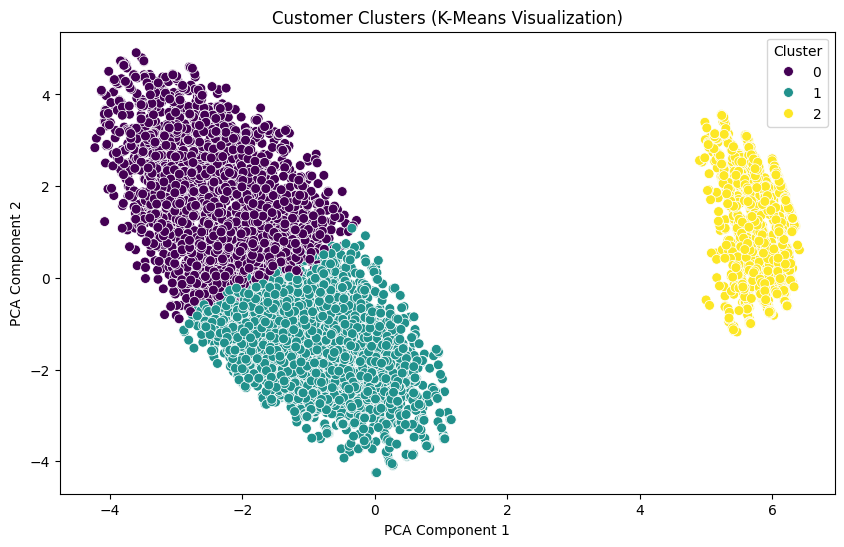

In [42]:
# @title 4. Clustering (K-Means)
# We cluster the clean data into 3 groups
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_clean)

# Visualize clusters using PCA (Compressing to 2D for the plot)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=50)
plt.title('Customer Clusters (K-Means Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

---

### **Step 5: Ensemble Model (Balanced Random Forest)**

We use **Balanced Random Forest**, which is specifically designed for imbalanced datasets (like Churn data). This was imported in your `Balancing techniques.ipynb`.

--- Balanced Random Forest Results ---
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       971
           1       0.52      0.70      0.60       367

    accuracy                           0.74      1338
   macro avg       0.70      0.73      0.70      1338
weighted avg       0.78      0.74      0.75      1338



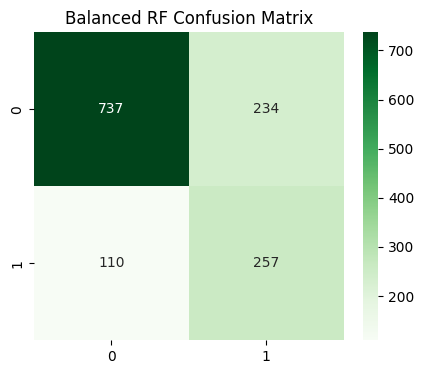

In [43]:
# @title 5. Ensemble Learning (Balanced Random Forest)
# Source: Balancing techniques.ipynb

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Initialize Balanced Random Forest
# This model down-samples the majority class internally during training
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf_model.fit(X_train, y_train)

# Predict
y_pred_brf = brf_model.predict(X_test)

# Evaluate
print("--- Balanced Random Forest Results ---")
print(classification_report(y_test, y_pred_brf))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_brf), annot=True, fmt='d', cmap='Greens')
plt.title('Balanced RF Confusion Matrix')
plt.show()

---

### **Step 6: SVM with SMOTE**

For SVM (`svm- with breast cancer (1).ipynb`), we need to manually balance the data first. We use **SMOTE** (Synthetic Minority Over-sampling Technique) as detailed in `Balancing techniques.ipynb`.

Training data shape before SMOTE: {0: 3865, 1: 1487}
Training data shape after SMOTE: {0: 3865, 1: 3865}

--- SVM Results ---
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       971
           1       0.53      0.72      0.61       367

    accuracy                           0.75      1338
   macro avg       0.71      0.74      0.71      1338
weighted avg       0.78      0.75      0.76      1338



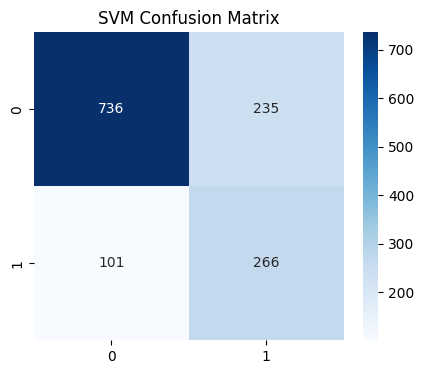

In [44]:
# @title 6. SVM with SMOTE Balancing
# Source: Balancing techniques.ipynb & svm- with breast cancer (1).ipynb

# 1. Apply SMOTE to training data ONLY
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Training data shape before SMOTE: {y_train.value_counts().to_dict()}")
print(f"Training data shape after SMOTE: {y_train_smote.value_counts().to_dict()}")

# 2. Train SVM
# RBF kernel is standard for complex non-linear data
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X_train_smote, y_train_smote)

# 3. Predict
y_pred_svm = svm_model.predict(X_test)

# 4. Evaluate
print("\n--- SVM Results ---")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

In [45]:
import joblib

# Save the StandardScaler
joblib.dump(scaler, 'scaler.pkl')

# Save the Balanced Random Forest model
joblib.dump(brf_model, 'brf_model.pkl')

# Save the SVM model
joblib.dump(svm_model, 'svm_model.pkl')

print("Scaler and models saved successfully!")

Scaler and models saved successfully!


In [46]:
!pip install streamlit

### **Step 7: Create Streamlit Application Script**

Now, let's create the `app.py` file for our Streamlit application. This script will load the saved models and scaler, and provide a simple interface for predicting customer churn.

In [47]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load the scaler and models
scaler = joblib.load('scaler.pkl')
brf_model = joblib.load('brf_model.pkl')
svm_model = joblib.load('svm_model.pkl')

# --- Streamlit UI ---
st.title('Telco Customer Churn Prediction')
st.write('Predict whether a customer will churn based on their characteristics.')

# Input features from the user
# These need to match the columns after one-hot encoding and scaling
# For simplicity, let's create a few key inputs. In a real app, you'd add all 30 features.

st.sidebar.header('Customer Information')

tenure = st.sidebar.slider('Tenure (months)', 0, 72, 12)
monthly_charges = st.sidebar.slider('Monthly Charges', 18.0, 118.0, 50.0)
total_charges = st.sidebar.slider('Total Charges', 0.0, 9000.0, 1000.0)

senior_citizen = st.sidebar.selectbox('Senior Citizen', ['No', 'Yes'])
partner = st.sidebar.selectbox('Partner', ['No', 'Yes'])
dependents = st.sidebar.selectbox('Dependents', ['No', 'Yes'])
phone_service = st.sidebar.selectbox('Phone Service', ['No', 'Yes'])
internet_service = st.sidebar.selectbox('Internet Service', ['DSL', 'Fiber optic', 'No'])
contract = st.sidebar.selectbox('Contract', ['Month-to-month', 'One year', 'Two year'])
paperless_billing = st.sidebar.selectbox('Paperless Billing', ['No', 'Yes'])
payment_method = st.sidebar.selectbox('Payment Method', ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'])

gender = st.sidebar.selectbox('Gender', ['Female', 'Male'])
multiple_lines = st.sidebar.selectbox('Multiple Lines', ['No', 'Yes', 'No phone service'])
online_security = st.sidebar.selectbox('Online Security', ['No', 'Yes', 'No internet service'])
online_backup = st.sidebar.selectbox('Online Backup', ['No', 'Yes', 'No internet service'])
device_protection = st.sidebar.selectbox('Device Protection', ['No', 'Yes', 'No internet service'])
tech_support = st.sidebar.selectbox('Tech Support', ['No', 'Yes', 'No internet service'])
streaming_tv = st.sidebar.selectbox('Streaming TV', ['No', 'Yes', 'No internet service'])
streaming_movies = st.sidebar.selectbox('Streaming Movies', ['No', 'Yes', 'No internet service'])


# Function to prepare input data for prediction
def preprocess_input(tenure, monthly_charges, total_charges, senior_citizen, partner, dependents, phone_service, internet_service, contract, paperless_billing, payment_method, gender, multiple_lines, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies):
    # Create a dictionary for the input features
    input_dict = {
        'tenure': tenure,
        'MonthlyCharges': monthly_charges,
        'TotalCharges': total_charges,
        'SeniorCitizen': 1 if senior_citizen == 'Yes' else 0,
        'Partner_Yes': 1 if partner == 'Yes' else 0,
        'Dependents_Yes': 1 if dependents == 'Yes' else 0,
        'PhoneService_Yes': 1 if phone_service == 'Yes' else 0,
        'PaperlessBilling_Yes': 1 if paperless_billing == 'Yes' else 0,
        'gender_Male': 1 if gender == 'Male' else 0
    }

    # Handle one-hot encoding for categorical features that were in the original dataset
    # Initialize all possible dummy columns to 0 (False)
    all_columns_X_encoded = [
        'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male',
        'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
        'MultipleLines_No phone service', 'MultipleLines_Yes',
        'InternetService_Fiber optic', 'InternetService_No',
        'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
        'OnlineBackup_No internet service', 'OnlineBackup_Yes',
        'DeviceProtection_No internet service', 'DeviceProtection_Yes',
        'TechSupport_No internet service', 'TechSupport_Yes',
        'StreamingTV_No internet service', 'StreamingTV_Yes',
        'StreamingMovies_No internet service', 'StreamingMovies_Yes',
        'Contract_One year', 'Contract_Two year',
        'PaperlessBilling_Yes',
        'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check',
        'PaymentMethod_Mailed check'
    ]

    # Create a dataframe with all expected columns and initialize to 0
    processed_df = pd.DataFrame(0, index=[0], columns=all_columns_X_encoded)

    # Fill in the input values
    processed_df['tenure'] = tenure
    processed_df['MonthlyCharges'] = monthly_charges
    processed_df['TotalCharges'] = total_charges
    processed_df['SeniorCitizen'] = 1 if senior_citizen == 'Yes' else 0
    processed_df['Partner_Yes'] = 1 if partner == 'Yes' else 0
    processed_df['Dependents_Yes'] = 1 if dependents == 'Yes' else 0
    processed_df['PhoneService_Yes'] = 1 if phone_service == 'Yes' else 0
    processed_df['PaperlessBilling_Yes'] = 1 if paperless_billing == 'Yes' else 0
    processed_df['gender_Male'] = 1 if gender == 'Male' else 0

    # Handle MultipleLines
    if multiple_lines == 'No phone service':
        processed_df['MultipleLines_No phone service'] = 1
    elif multiple_lines == 'Yes':
        processed_df['MultipleLines_Yes'] = 1

    # Handle InternetService
    if internet_service == 'Fiber optic':
        processed_df['InternetService_Fiber optic'] = 1
    elif internet_service == 'No':
        processed_df['InternetService_No'] = 1

    # Handle OnlineSecurity
    if online_security == 'No internet service':
        processed_df['OnlineSecurity_No internet service'] = 1
    elif online_security == 'Yes':
        processed_df['OnlineSecurity_Yes'] = 1

    # Handle OnlineBackup
    if online_backup == 'No internet service':
        processed_df['OnlineBackup_No internet service'] = 1
    elif online_backup == 'Yes':
        processed_df['OnlineBackup_Yes'] = 1

    # Handle DeviceProtection
    if device_protection == 'No internet service':
        processed_df['DeviceProtection_No internet service'] = 1
    elif device_protection == 'Yes':
        processed_df['DeviceProtection_Yes'] = 1

    # Handle TechSupport
    if tech_support == 'No internet service':
        processed_df['TechSupport_No internet service'] = 1
    elif tech_support == 'Yes':
        processed_df['TechSupport_Yes'] = 1

    # Handle StreamingTV
    if streaming_tv == 'No internet service':
        processed_df['StreamingTV_No internet service'] = 1
    elif streaming_tv == 'Yes':
        processed_df['StreamingTV_Yes'] = 1

    # Handle StreamingMovies
    if streaming_movies == 'No internet service':
        processed_df['StreamingMovies_No internet service'] = 1
    elif streaming_movies == 'Yes':
        processed_df['StreamingMovies_Yes'] = 1

    # Handle Contract
    if contract == 'One year':
        processed_df['Contract_One year'] = 1
    elif contract == 'Two year':
        processed_df['Contract_Two year'] = 1

    # Handle PaymentMethod
    if payment_method == 'Credit card (automatic)':
        processed_df['PaymentMethod_Credit card (automatic)'] = 1
    elif payment_method == 'Electronic check':
        processed_df['PaymentMethod_Electronic check'] = 1
    elif payment_method == 'Mailed check':
        processed_df['PaymentMethod_Mailed check'] = 1

    # Scale the numerical features
    scaled_features = scaler.transform(processed_df[processed_df.columns])
    scaled_df = pd.DataFrame(scaled_features, columns=processed_df.columns)

    return scaled_df


# Make prediction button
if st.sidebar.button('Predict Churn'):
    input_data = preprocess_input(tenure, monthly_charges, total_charges, senior_citizen, partner, dependents, phone_service, internet_service, contract, paperless_billing, payment_method, gender, multiple_lines, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies)

    st.subheader('Prediction Results')

    brf_prediction = brf_model.predict(input_data)[0]
    svm_prediction = svm_model.predict(input_data)[0]

    if brf_prediction == 1:
        st.error('Balanced Random Forest predicts: Customer will CHURN')
    else:
        st.success('Balanced Random Forest predicts: Customer will NOT CHURN')

    if svm_prediction == 1:
        st.error('SVM predicts: Customer will CHURN')
    else:
        st.success('SVM predicts: Customer will NOT CHURN')

    st.write('---')
    st.write('Disclaimer: These predictions are based on the trained models and provided inputs. Please use for informational purposes only.')


Overwriting app.py


After the installation completes, please try running your Streamlit app again with the command:

```bash
streamlit run app.py
```

### **Step 8: Run the Streamlit Application**

To run the Streamlit application, follow these steps:

1.  **Install Streamlit**: If you haven't already, install Streamlit in your Colab environment or locally:
    ```bash
    pip install streamlit
    ```

2.  **Run the App**: Execute the following command in your terminal or a new Colab code cell (if running locally, navigate to the directory where `app.py` is saved):
    ```bash
    streamlit run app.py
    ```

    If running in Colab, this will typically provide a local URL and an external URL. Click on the external URL to access your Streamlit app in a new browser tab.

You can interact with the sidebar widgets to change customer characteristics and see the churn predictions from both models.